detect Fire from the images provided

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Sequential   # Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
from keras.layers import Dense    # the neurons in the dense layer get their source of input data from all the other neurons of the previous layer of the network
from keras.layers import Flatten    #converts the multi-dimensional arrays into flattened one-dimensional arrays or single-dimensional arrays
from keras.layers import Activation
from keras.layers import Dropout    # provide a rate that sets the frequency of which input units are randomly set to 0 (dropped out).
from keras.layers import BatchNormalization   #Layer that normalizes its inputs. maintains the mean output close to 0 and the output standard deviation close to 1.

from keras.layers import MaxPooling2D     # he window size which takes the maximum value into the pooling window which was 2*2. uses it to create a downsampled (pooled) feature map
from keras.layers import Convolution2D
from keras.layers import Conv2D   #a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.

from keras.preprocessing.image import ImageDataGenerator    #used to take the inputs of the original data and then transform it on a random basis
from keras.preprocessing.image import load_img

from keras import utils

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import random
import os
import cv2

In [2]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels =3

In [3]:
filenames = os.listdir("C:/Users/DELL/Desktop/DA/Assignments/Fire/Fire")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
filenames = os.listdir("C:/Users/DELL/Desktop/DA/Assignments/Fire/Non Fire")
categories = []
new_rows_df=[]
for filename in filenames:
  category = filename.split('.')[0]
  new_rows_df.append({'filename': filename,'category': 0})


df = df.append(new_rows_df, ignore_index=True)

# new_rows_df = pd.DataFrame({
#     'filename': filenames,
#     'category': categories
# })

C:\Users\DELL\AppData\Local\Temp\ipykernel_2552\1917714917.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_rows_df, ignore_index=True)


In [5]:
df.sample(5)

,filename,category
3,105.jpg,1
51,189.jpg,1
178,59.jpg,0
7,111.jpg,1
176,56.jpg,0


<Axes: >

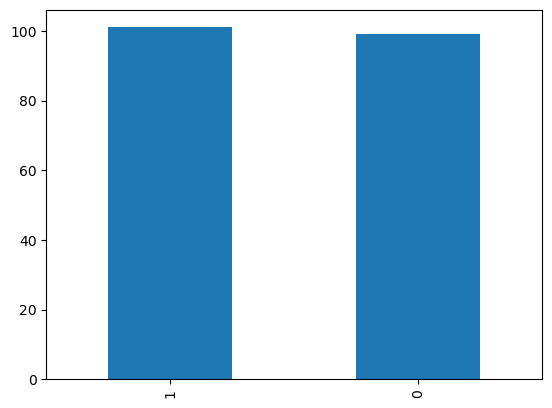

In [6]:
df['category'].value_counts().plot.bar()

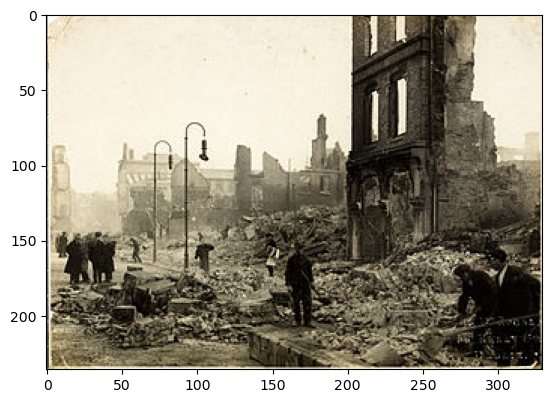

In [7]:
sample = random.choice(filenames)
img = load_img("C:/Users/DELL/Desktop/DA/Assignments/Fire/All Pictures/"+sample)
plt.imshow(img)

In [8]:
model = Sequential()

model.add(Conv2D( 32, (3,3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels)))
model.add( BatchNormalization())
model.add( MaxPooling2D(pool_size=(2,2 )))
model.add( Dropout(0.25))

model.add(Conv2D( 64, (3,3), activation='relu'))
model.add( BatchNormalization())
model.add( MaxPooling2D(pool_size=(2,2 )))
model.add( Dropout(0.25))

model.add(Conv2D( 128, (3,3), activation='relu'))
model.add( BatchNormalization())
model.add( MaxPooling2D(pool_size=(2,2 )))
model.add( Dropout(0.25))

In [9]:
model.add(Flatten( input_shape=[28,28] ))
model.add(Dense( 512, activation='relu' ))
model.add( BatchNormalization())
model.add( Dropout(0.5))
model.add(Dense( 2, activation='softmax' ))

In [10]:
model.compile( loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'] )

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [12]:
earlystop =EarlyStopping(patience=10)

learn_rate_reduction = ReduceLROnPlateau( monitor='val_accuracy', patience =2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learn_rate_reduction]

In [13]:
df['category'] = df['category'].replace({0:'not fire', 1:'fire'})

train_df, validate_df = train_test_split( df, test_size=0.2, random_state=42)
train_df = train_df.reset_index( drop=True)
validate_df = validate_df.reset_index( drop=True)

<Axes: >

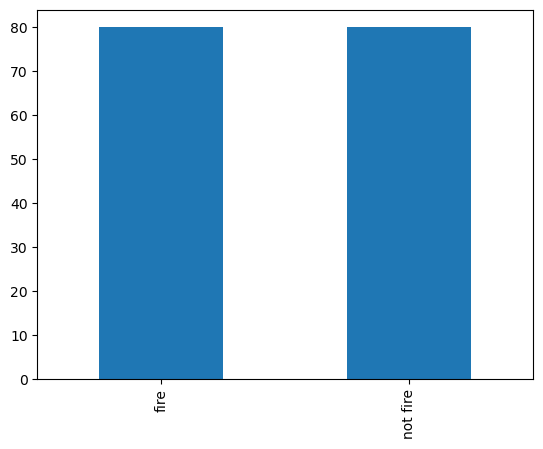

In [14]:
train_df['category'].value_counts().plot.bar()

<Axes: >

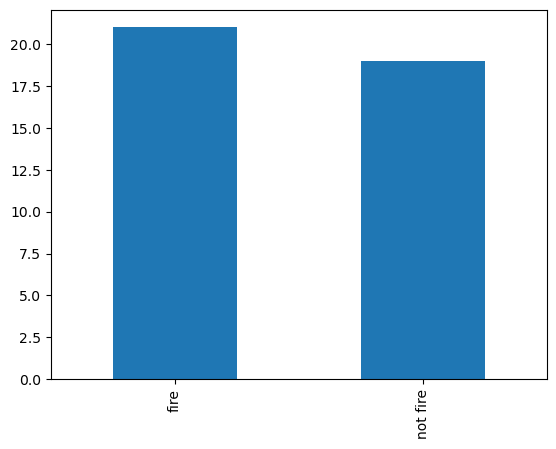

In [15]:
validate_df['category'].value_counts().plot.bar()

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

flow_from_dataframe: takes the Pandas DataFrame and the path to a directory and generates batches of augmented/normalized data.

In [17]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255 , shear_range=0.1,zoom_range=0.2, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df, "C:/Users/DELL/Desktop/DA/Assignments/Fire/All Pictures", x_col="filename" , y_col="category" , target_size=Image_Size, batch_size=batch_size, class_mode='categorical')

Found 160 validated image filenames belonging to 2 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(validate_df, "C:/Users/DELL/Desktop/DA/Assignments/Fire/All Pictures", x_col="filename" , y_col="category" , target_size=Image_Size, batch_size=batch_size, class_mode='categorical')

Found 40 validated image filenames belonging to 2 classes.


In [19]:
ex_df = train_df.sample(n=1).reset_index(drop=True)
ex_generator = train_datagen.flow_from_dataframe(ex_df,"C:/Users/DELL/Desktop/DA/Assignments/Fire/All Pictures", x_col = 'filename',y_col ='category', target_size=Image_Size,class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


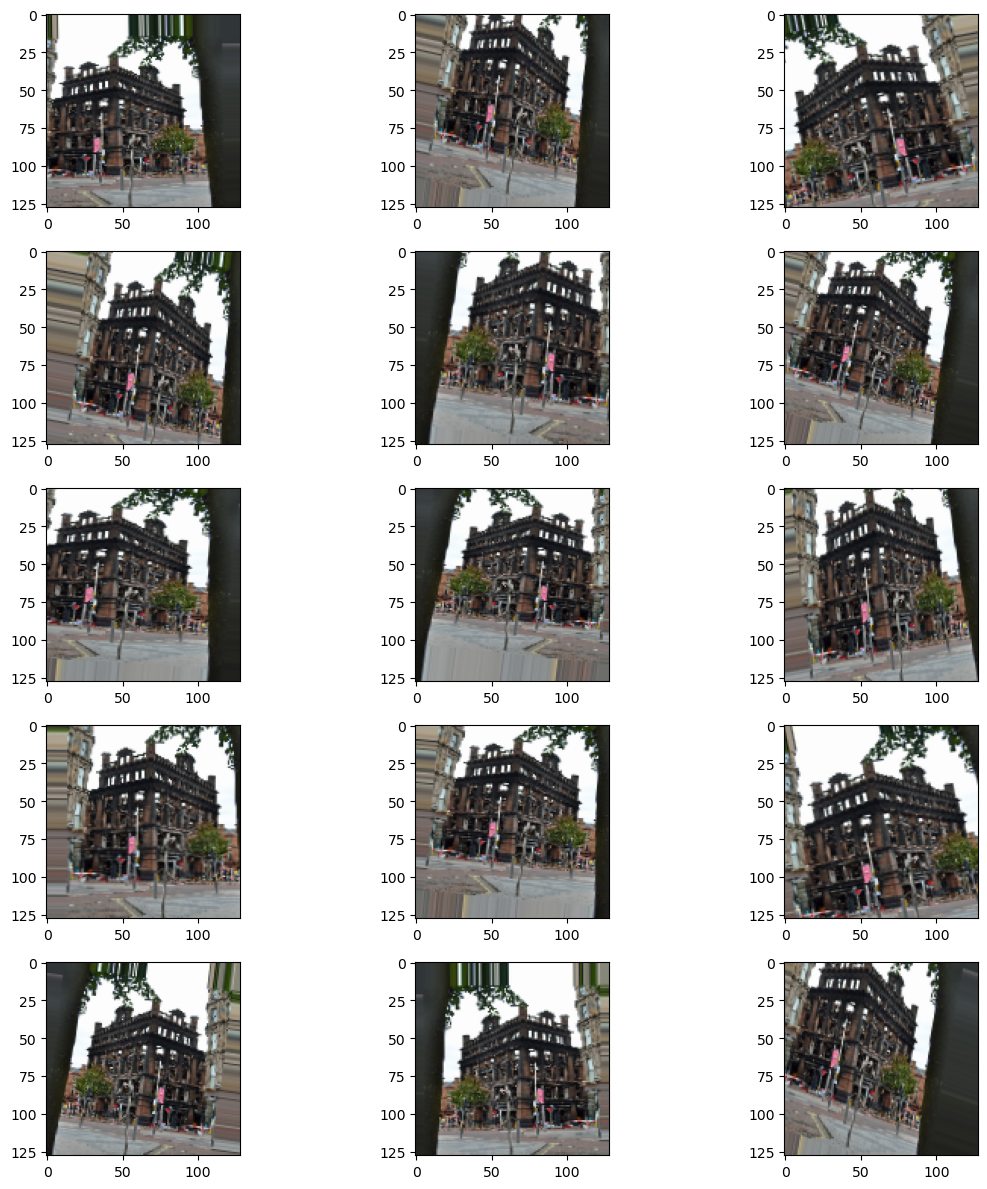

In [20]:
plt.figure(figsize=(12,12))
for i in range(0,15):
  plt.subplot(5,3,i+1)
  for x_batch, y_batch in ex_generator:
    img = x_batch[0]
    plt.imshow(img)
    break
plt.tight_layout()
plt.show()

In [21]:
Fast_Run = False
epochs = 3 if Fast_Run else 50
history = model.fit( train_generator, epochs=3, validation_data=validation_generator, validation_steps=total_validate//batch_size, steps_per_epoch=total_train//batch_size, callbacks=callbacks )
model.save('model.h5')

Epoch 1/3
10/10 [==============================] - 28s 2s/step - loss: 1.3297 - accuracy: 0.6966 - val_loss: 0.5967 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 2/3
10/10 [==============================] - 15s 1s/step - loss: 0.8008 - accuracy: 0.7379 - val_loss: 1.2781 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/3
10/10 [==============================] - ETA: 0s - loss: 0.9195 - accuracy: 0.7310
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 [==============================] - 9s 894ms/step - loss: 0.9195 - accuracy: 0.7310 - val_loss: 1.8640 - val_accuracy: 0.5667 - lr: 0.0010


C:\Anaconda1\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


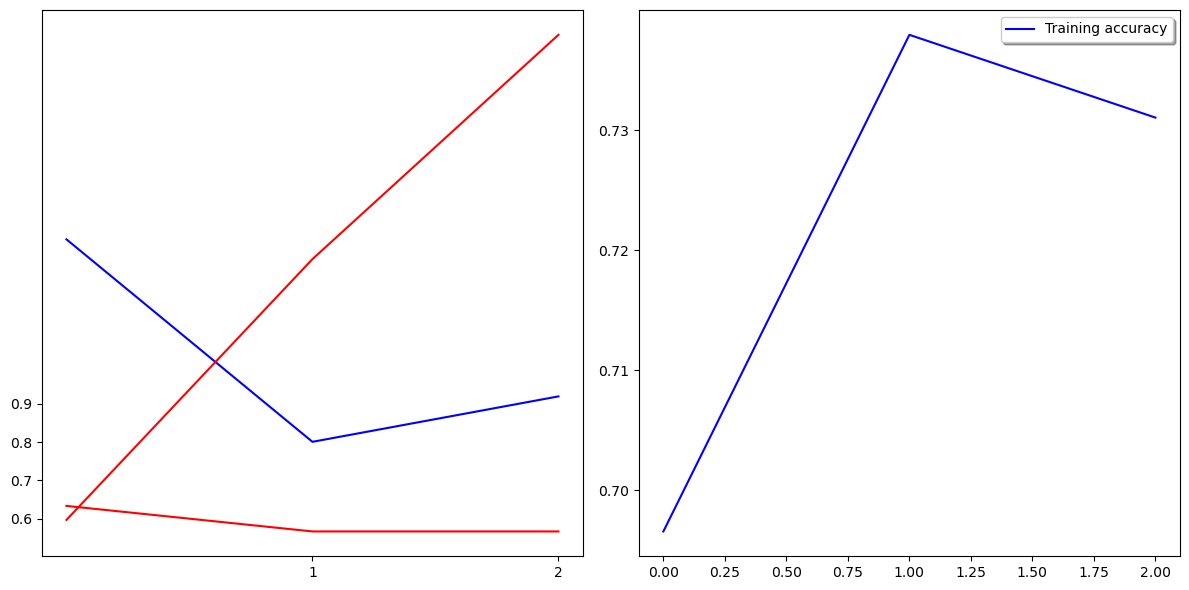

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='validation_loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0,1,0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
ax1.plot(history.history['val_accuracy'], color='r', label='validation_accuracy')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels =3

for i in range(10):
    all_test_images = os.listdir("C:/Users/DELL/Desktop/DA/Assignments/Fire/All Pictures")
    random_image = random.choice(all_test_images)
    print(random_image)
    img = cv2.imread(f'C:/Users/DELL/Desktop/DA/Assignments/Fire/All Pictures/{random_image}')
    
    img = cv2.resize(img,(Image_Height, Image_Width))
   
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(['fire','not fire'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()                                  

147.jpg
1/1 [==============================] - 0s 192ms/step
fire
